In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from timple.timedelta import strftimedelta
import fastf1 as ff1
import fastf1.plotting as ff1pl
from fastf1.core import Laps
import re

In [9]:
ff1.Cache.enable_cache('../cache')
ff1pl.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False)

In [10]:
session = ff1.get_session(2023, 'Australia', 'Q')
session.load()

core           INFO 	Loading data for Australian Grand Prix - Qualifying [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
C:\Users\Ricky\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1492: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, value in row.iteritems():
C:\Users\Ricky\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=False)
C:\Users\Ricky\AppData\Local\Programs

In [11]:
drivers = pd.unique(session.laps['Driver'])
print(drivers)

['VER' 'RUS' 'HAM' 'ALO' 'SAI' 'STR' 'LEC' 'ALB' 'GAS' 'HUL' 'OCO' 'TSU'
 'NOR' 'MAG' 'DEV' 'PIA' 'ZHO' 'SAR' 'BOT' 'PER']


In [12]:
list_fastest_laps = list()
for drv in drivers:
    drvs_fastest_lap = session.laps.pick_driver(drv).pick_fastest()
    list_fastest_laps.append(drvs_fastest_lap)
fastest_laps = Laps(list_fastest_laps).sort_values(by='LapTime').reset_index(drop=True)

C:\Users\Ricky\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2328: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  super().__init__(*args, **kwargs)


In [20]:
pole_lap = fastest_laps.pick_fastest().dropna()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']
print(fastest_laps[['Driver', 'LapTime', 'LapTimeDelta']].dropna())

   Driver                LapTime           LapTimeDelta
0     VER 0 days 00:01:16.732000        0 days 00:00:00
1     RUS 0 days 00:01:16.968000 0 days 00:00:00.236000
2     HAM 0 days 00:01:17.104000 0 days 00:00:00.372000
3     ALO 0 days 00:01:17.139000 0 days 00:00:00.407000
4     SAI 0 days 00:01:17.270000 0 days 00:00:00.538000
5     STR 0 days 00:01:17.308000 0 days 00:00:00.576000
6     LEC 0 days 00:01:17.369000 0 days 00:00:00.637000
7     ALB 0 days 00:01:17.609000 0 days 00:00:00.877000
8     GAS 0 days 00:01:17.675000 0 days 00:00:00.943000
9     HUL 0 days 00:01:17.735000 0 days 00:00:01.003000
10    OCO 0 days 00:01:17.768000 0 days 00:00:01.036000
11    TSU 0 days 00:01:18.099000 0 days 00:00:01.367000
12    NOR 0 days 00:01:18.119000 0 days 00:00:01.387000
13    MAG 0 days 00:01:18.129000 0 days 00:00:01.397000
14    DEV 0 days 00:01:18.335000 0 days 00:00:01.603000
15    PIA 0 days 00:01:18.517000 0 days 00:00:01.785000
16    ZHO 0 days 00:01:18.540000 0 days 00:00:01

In [50]:
filtered_fastest_laps = fastest_laps.dropna(subset=['Team'])

team_colors = list()
for index, lap in filtered_fastest_laps.iterrows():
    color = ff1.plotting.team_color(lap['Team'])
    team_colors.append(color)

# GAP to Leader
# modified_fastest_laps = filtered_fastest_laps.copy()
# modified_fastest_laps['LapTimeDeltaString'] = modified_fastest_laps['LapTimeDelta'].apply(lap_time_delta_to_string)

# INTERVALS
modified_fastest_laps['Interval'] = modified_fastest_laps['LapTime'].diff()
modified_fastest_laps['IntervalString'] = modified_fastest_laps['Interval'].apply(lap_time_delta_to_string)

In [30]:
plot_size = [10, 10]
plot_title = f"{session.event['EventName']} {session.event.year} Qualifying\n Fastest Lap: {lap_time_string} ({pole_lap['Driver']})"
plot_filename = re.sub(r'\W+', '', plot_title.replace("\n", " ")) + ".png"

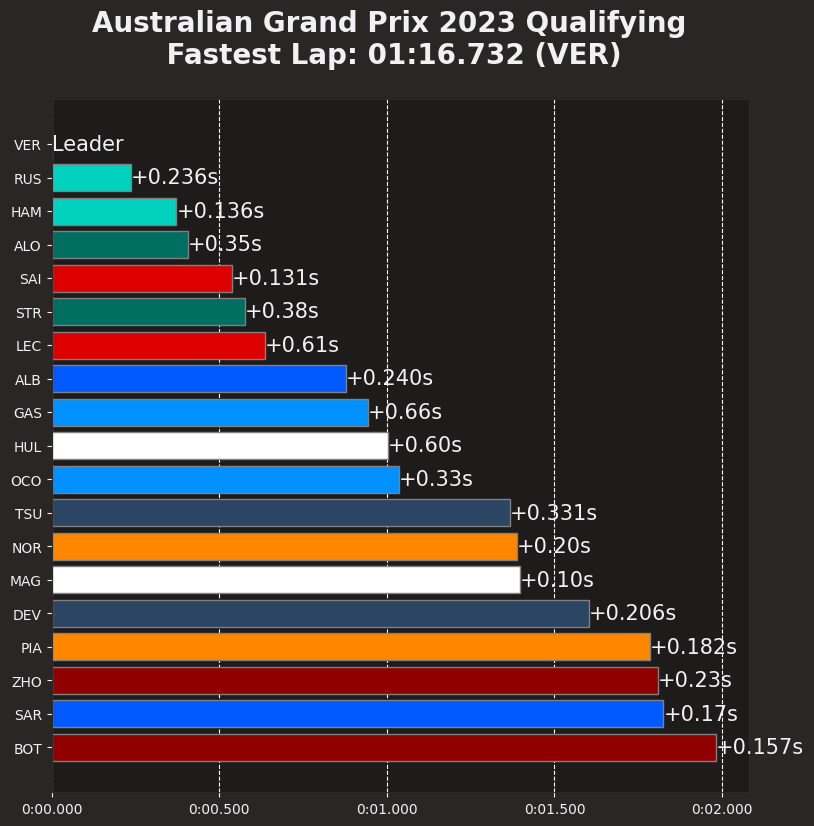

In [53]:
plt.rcParams['figure.figsize'] = [9,9]
fig, ax = plt.subplots()
ax.barh(filtered_fastest_laps.index, filtered_fastest_laps['LapTimeDelta'],
        color=team_colors, edgecolor='grey')
ax.set_yticks(filtered_fastest_laps.index)
ax.set_yticklabels(filtered_fastest_laps['Driver'])

# show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='white', zorder=-1000)
lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')

plt.suptitle(plot_title, size=20, fontweight='bold')

# Add the interval on the bars
for i, rect in enumerate(bars[:len(modified_fastest_laps)]):
    x = rect.get_width()
    y = rect.get_y() + rect.get_height() / 2
    
    # Display gap to the leader for the first bar and interval for the rest
    if i == 0:
        text = modified_fastest_laps.iloc[i]['LapTimeDeltaString']
    else:
        text = modified_fastest_laps.iloc[i]['IntervalString']
    
    ax.text(x, y, text, ha='left', va='center', size=15)

# Add the gap to the leader on the bars
# bars = ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
#                color=team_colors, edgecolor='grey')
# for i, rect in enumerate(bars[:len(modified_fastest_laps)]):
#     x = rect.get_width()
#     y = rect.get_y() + rect.get_height() / 2
#     gap = modified_fastest_laps.iloc[i]['LapTimeDeltaString']
#     ax.text(x, y, gap, ha='left', va='center', size=15)

plt.show()